In [19]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [20]:
class Population:
    def __init__(self, p, N, w=(1, 1, 1), mu=0, nu=0, m=0, p_m=0.5, stochastic=False):
        self.p = p
        self.q = 1 - p
        self.N = N
        self.w_AA, self.w_Aa, self.w_aa = w
        self.mu = mu
        self.nu = nu
        self.m = m
        self.p_m = p_m
        self.stochastic = stochastic

    def apply_mutation(self):
        self.p = (1 - self.mu) * self.p + self.nu * self.q
        self.q = 1 - self.p

    def compute_genotype_freqs(self):
        return self.p**2, 2 * self.p * self.q, self.q**2

    def apply_selection(self, f_AA, f_Aa, f_aa):
        w_bar = f_AA * self.w_AA + f_Aa * self.w_Aa + f_aa * self.w_aa
        f_AA_sel = (f_AA * self.w_AA) / w_bar
        f_Aa_sel = (f_Aa * self.w_Aa) / w_bar
        f_aa_sel = (f_aa * self.w_aa) / w_bar
        return f_AA_sel, f_Aa_sel, f_aa_sel

    def apply_migration(self):
        self.p = (1 - self.m) * self.p + self.m * self.p_m
        self.q = 1 - self.p

    def apply_drift(self):
        alleles = np.random.binomial(2 * self.N, self.p)
        self.p = alleles / (2 * self.N)
        self.q = 1 - self.p


In [21]:
class HardyWeinbergSimulator:
    def __init__(self, population, generations):
        self.population = population
        self.generations = generations
        self.data = []

    def simulate(self):
        for gen in range(self.generations + 1):
            p, q = self.population.p, self.population.q
            f_AA, f_Aa, f_aa = self.population.compute_genotype_freqs()
            self.data.append((gen, p, q, f_AA, f_Aa, f_aa))

            if gen == self.generations:
                break

            self.population.apply_mutation()
            f_AA, f_Aa, f_aa = self.population.compute_genotype_freqs()
            f_AA, f_Aa, f_aa = self.population.apply_selection(f_AA, f_Aa, f_aa)
            self.population.p = f_AA + 0.5 * f_Aa
            self.population.q = 1 - self.population.p
            self.population.apply_migration()
            if self.population.stochastic:
                self.population.apply_drift()

        self.df = pd.DataFrame(self.data, columns=["Generation", "p", "q", "f_AA", "f_Aa", "f_aa"])

    def test_equilibrium(self, generation=-1):
        row = self.df.iloc[generation]
        p, q = row["p"], row["q"]
        expected = np.array([p**2, 2*p*q, q**2]) * self.population.N
        observed = np.array([row["f_AA"], row["f_Aa"], row["f_aa"]]) * self.population.N
        chi2_stat = np.sum((observed - expected) ** 2 / expected)
        p_val = 1 - chi2.cdf(chi2_stat, df=1)
        return chi2_stat, p_val

    def plot_frequencies(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.df["Generation"], self.df["p"], label="Allele p")
        plt.plot(self.df["Generation"], self.df["q"], label="Allele q")
        plt.plot(self.df["Generation"], self.df["f_AA"], label="Genotype AA")
        plt.plot(self.df["Generation"], self.df["f_Aa"], label="Genotype Aa")
        plt.plot(self.df["Generation"], self.df["f_aa"], label="Genotype aa")
        plt.title("Allele and Genotype Frequencies Over Time")
        plt.xlabel("Generation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
def punnett_square_df(p: float):
    q = 1 - p

    data = {
        "A (p)": [f"AA = {p*p:.4f}", f"Aa = {p*q:.4f}"],
        "a (q)": [f"Aa = {q*p:.4f}", f"aa = {q*q:.4f}"]
    }
    index = ["A (p)", "a (q)"]
    df = pd.DataFrame(data, index=index)

    print("=== Punnett Square (Hardy-Weinberg) ===")
    display(df)

    f_AA = p ** 2
    f_Aa = 2 * p * q
    f_aa = q ** 2

    freq_summary = pd.DataFrame({
        "Genotype": ["AA", "Aa", "aa", "Total"],
        "Frequency": [f"{f_AA:.4f}", f"{f_Aa:.4f}", f"{f_aa:.4f}", f"{f_AA + f_Aa + f_aa:.4f}"]
    })

    print("\nGenotype frequencies:")
    display(freq_summary)

In [26]:
punnett_square_df(0.6)

=== Punnett Square (Hardy-Weinberg) ===


,A (p),a (q)
A (p),AA = 0.3600,Aa = 0.2400
a (q),Aa = 0.2400,aa = 0.1600



Genotype frequencies:


,Genotype,Frequency
0,AA,0.3600
1,Aa,0.4800
2,aa,0.1600
3,Total,1.0000


Chi-square: 0.0000, p-value: 1


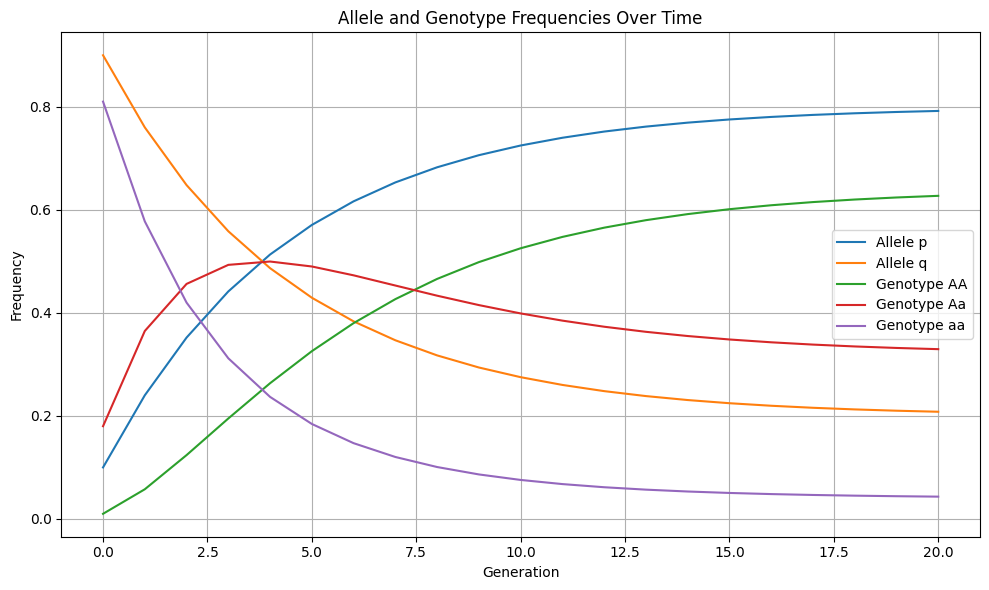

In [31]:
if __name__ == "__main__":
    pop = Population(p=0.1, N=1000, w=(1.0, 1.0, 1.0), mu=0.0, nu=0.0, m=0.2, p_m=0.8, stochastic=False)
    pop.apply_mutation()
    sim = HardyWeinbergSimulator(population=pop, generations=20)
    sim.simulate()
    chi2_stat, p_val = sim.test_equilibrium()
    print(f"Chi-square: {chi2_stat:.4f}, p-value: {p_val:.4g}")
    sim.plot_frequencies()